## THE BATTLE OF NEIGHBORHOODS - Applied Data Science Capstone Project

### Introduction

New York City's is a large and ethnically diverse cosmopolit and food is one of the major items that create the diversity. There are countless resturants in the New york City, in fact, NYC is a place where you can find literally every single kind of food in the world. This also creates an incredible competitive food market with all restaurants are doing their best to capture new customers.

With these in mind, our goal in this project is to find the best location for the new Turkish restaurant we are planning to open.

### Data

For this project we need the city's data with Boroughs, Neighborhoods along with their latitude and longitude, Turkish resturants in each neighborhood, and GeoSpace data of the city.

### Questions to be answered in this project

1) Which are the best locations in NYC for Turkish food?

2) Which areas have the best potential to open a new one?

### Methodology

1. Collecting the New York city data from "https://cocl.us/new_york_dataset".
2. Finding all venues for each neighborhood using FourSquare API.
3. Filter out all Turkish Restuarant venues.
4. Using FourSquare API, find the Ratings, Tips, and Like count for all the Turkish Resturants.
5. Sort the data keeping Ratings as the constraint.
6. Visualize the Ranking of neighborhoods using python's Folium library.

### Starting with importing the necessary libraries

In [6]:
pip install beautifulsoup4

     |████████████████████████████████| 112kB 8.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

### Defining the function to get the geocodes

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Defining a function to interact with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [8]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'JK0Q54RHCTMDKLIHUXNNZ5CFGIDN4C2UTCVT1XRWNKTSSGCU' # your Foursquare ID
    CLIENT_SECRET = 'PJQ3VK5JHGQKFRU41BACZM4EOUG0V3RD1NANBOMMUEYRGXST' # your Foursquare Secret
    VERSION = '20200517' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Defining a function to get venue details

In [9]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'JK0Q54RHCTMDKLIHUXNNZ5CFGIDN4C2UTCVT1XRWNKTSSGCU' # your Foursquare ID
    CLIENT_SECRET = 'PJQ3VK5JHGQKFRU41BACZM4EOUG0V3RD1NANBOMMUEYRGXST' # your Foursquare Secret
    VERSION = '20200517' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Getting NYC Data

In [10]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [11]:
new_york_data=get_new_york_data()

In [12]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
new_york_data.shape

(306, 4)

### Collecting Turkish Restaurants in NYC

In [14]:
# prepare neighborhood list that contains Turkish resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
turkish_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    turkish_resturants=venues[venues['Category']=='Turkish Restaurant']   
    print('(',count,'/',len(new_york_data),')','Turkish Resturants in '+Neighborhood+', '+Borough+':'+str(len(turkish_resturants)))
    for resturant_detail in turkish_resturants.values.tolist():
        id, name , category=resturant_detail
        turkish_rest_ny = turkish_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Turkish Resturants in Wakefield, Bronx:0
( 2 / 306 ) Turkish Resturants in Co-op City, Bronx:0
( 3 / 306 ) Turkish Resturants in Eastchester, Bronx:0
( 4 / 306 ) Turkish Resturants in Fieldston, Bronx:0
( 5 / 306 ) Turkish Resturants in Riverdale, Bronx:0
( 6 / 306 ) Turkish Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Turkish Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Turkish Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Turkish Resturants in Norwood, Bronx:0
( 10 / 306 ) Turkish Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Turkish Resturants in Baychester, Bronx:0
( 12 / 306 ) Turkish Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Turkish Resturants in City Island, Bronx:0
( 14 / 306 ) Turkish Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Turkish Resturants in University Heights, Bronx:0
( 16 / 306 ) Turkish Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Turkish Resturants in Fordham, Bronx:0
( 18 / 306 ) Turkish Resturants in East Tremont, Bronx:

In [15]:
turkish_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay
1,Brooklyn,Bay Ridge,4d420ba9f0dba1cd6c752f49,Hazar Turkish Kebab
2,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon
3,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
4,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant


In [17]:
turkish_rest_ny.shape

(28, 4)

### We see that there are currently 28 Turkish Restaurants in NYC

Lets create a bar plot to see where those Turkish Restaurants are

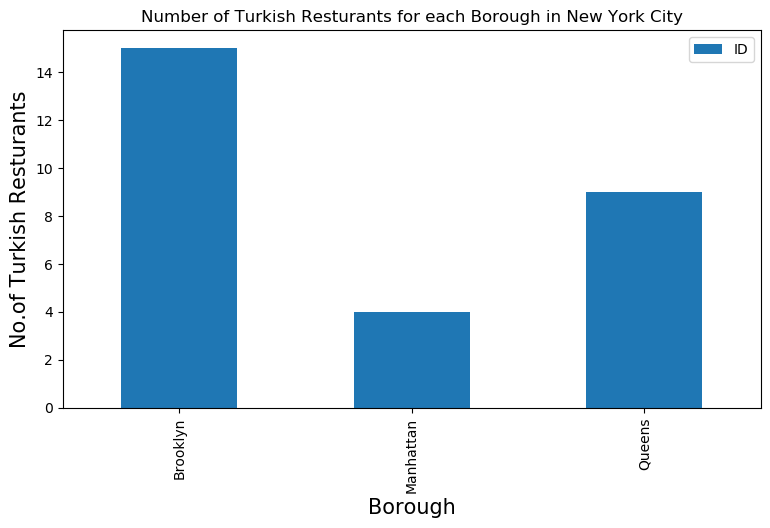

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Turkish Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Turkish Resturants', fontsize=15)
#giving a bar plot
turkish_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Lets create another one to see the neighborhoods

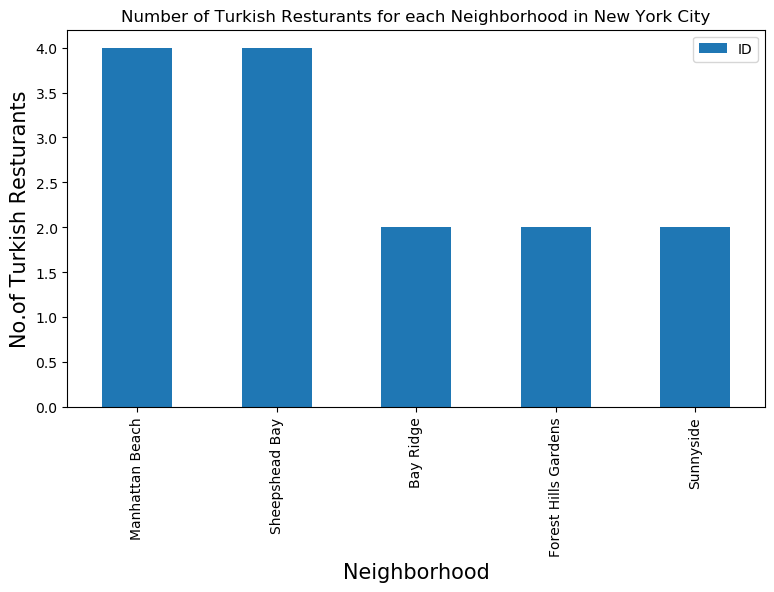

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Turkish Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Turkish Resturants', fontsize=15)
#giving a bar plot
turkish_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Rankings of these restaurants for further analysis

In [21]:
# prepare neighborhood list that contains Turkish resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
turkish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in turkish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(turkish_rest_ny),')','processed')
    turkish_rest_stats_ny = turkish_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID          Name  Likes  Rating  Tips
0  579d3e7c498effa33c0450af  Istanbul Bay     23     7.9     4
( 1 / 28 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4d420ba9f0dba1cd6c752f49  Hazar Turkish Kebab     44     8.1    25
( 2 / 28 ) processed
                         ID        Name  Likes  Rating  Tips
0  51a2a2a3498e0d5d337f137b  Wood Spoon      5     7.4     3
( 3 / 28 ) processed
                         ID               Name  Likes  Rating  Tips
0  4fcbfc92e4b088c92e7e97ad  Opera Cafe Lounge    257     8.3    53
( 4 / 28 ) processed
                         ID              Name  Likes  Rating  Tips
0  4b1d5405f964a520d70e24e3  Liman Restaurant     96     8.1    37
( 5 / 28 ) processed
                         ID                              Name  Likes  Rating  \
0  4a986cf5f964a520f32b20e3  Istanbul Restaurant Fish & Kebab     35     7.9   

   Tips  
0    15  
( 6 / 28 ) processed
                         ID        

In [22]:
turkish_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay,23,7.9,4
1,Brooklyn,Bay Ridge,4d420ba9f0dba1cd6c752f49,Hazar Turkish Kebab,44,8.1,25
2,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5,7.4,3
3,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge,257,8.3,53
4,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant,96,8.1,37


In [23]:
turkish_rest_stats_ny.shape

(28, 7)

In [24]:
turkish_rest_ny.shape

(28, 4)

### Creating a backup file for this dataset

In [25]:
turkish_rest_stats_ny.to_csv('turkish_rest_stats_ny.csv', index=False)

In [26]:
turkish_rest_stats_ny_csv=pd.read_csv('turkish_rest_stats_ny.csv')

In [28]:
turkish_rest_stats_ny_csv.shape

(28, 7)

In [29]:
turkish_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay,23,7.9,4
1,Brooklyn,Bay Ridge,4d420ba9f0dba1cd6c752f49,Hazar Turkish Kebab,44,8.1,25
2,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5,7.4,3
3,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge,257,8.3,53
4,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant,96,8.1,37


In [30]:
turkish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       28 non-null     object 
 1   Neighborhood  28 non-null     object 
 2   ID            28 non-null     object 
 3   Name          28 non-null     object 
 4   Likes         28 non-null     object 
 5   Rating        28 non-null     float64
 6   Tips          28 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.7+ KB


### Correcting the Data Types

In [31]:
turkish_rest_stats_ny['Likes']=turkish_rest_stats_ny['Likes'].astype('float64')
turkish_rest_stats_ny['Tips']=turkish_rest_stats_ny['Tips'].astype('float64')

In [32]:
turkish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       28 non-null     object 
 1   Neighborhood  28 non-null     object 
 2   ID            28 non-null     object 
 3   Name          28 non-null     object 
 4   Likes         28 non-null     float64
 5   Rating        28 non-null     float64
 6   Tips          28 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.7+ KB


### Identifying the Best Restaurants

In [33]:
# Resturant with maximum Likes
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              50fc9a88e4b04cfffaebe2cf
Name                             Sip Sak
Likes                                284
Rating                               8.9
Tips                                 101
Name: 24, dtype: object

In [34]:
# Resturant with maximum Rating
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood           Manhattan Terrace
ID              4a060d32f964a520b1721fe3
Name             Taci's Beyti Restaurant
Likes                                249
Rating                               8.9
Tips                                  67
Name: 7, dtype: object

In [35]:
# Resturant with maximum Tips
turkish_rest_stats_ny.iloc[turkish_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              50fc9a88e4b04cfffaebe2cf
Name                             Sip Sak
Likes                                284
Rating                               8.9
Tips                                 101
Name: 24, dtype: object

### Finding Best Neighborhoods in NYC for Turkish Food

In [36]:
ny_neighborhood_stats=turkish_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [43]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
9,Ocean Parkway,8.9
8,Manhattan Terrace,8.9
16,Turtle Bay,8.9
15,Tudor City,8.9
12,Steinway,8.6
10,Ravenswood,8.6
0,Astoria,8.6
13,Sunnyside,8.0
14,Sunnyside Gardens,8.0
2,Bay Ridge,8.0


### Finding Best Boroughs in NYC for Turkish Food

In [39]:
ny_borough_stats=turkish_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [40]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.425000
2,Queens,8.166667
0,Brooklyn,7.986667


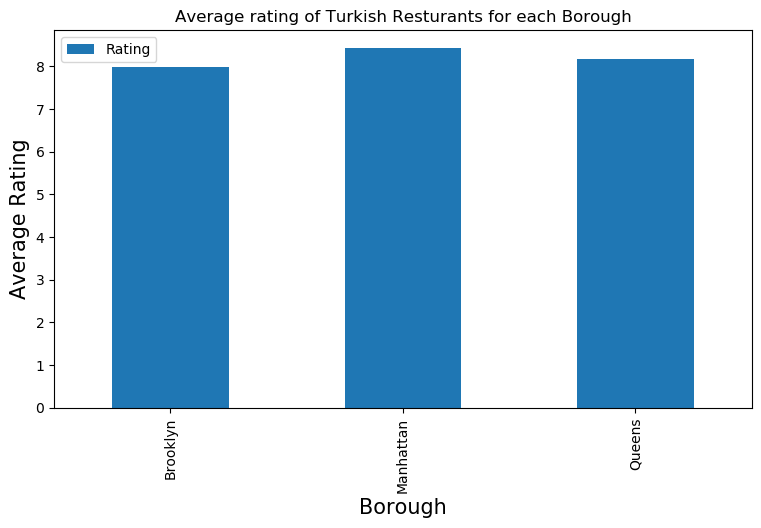

In [41]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Turkish Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
turkish_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Let's add the geocode to the neighborhoods

In [44]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [59]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
9,Brooklyn,Ocean Parkway,40.613060,-73.968367,8.900,"Ocean Parkway, Brooklyn(8.9)"
8,Brooklyn,Manhattan Terrace,40.614433,-73.957438,8.900,"Manhattan Terrace, Brooklyn(8.9)"
17,Manhattan,Turtle Bay,40.752042,-73.967708,8.900,"Turtle Bay, Manhattan(8.9)"
16,Manhattan,Tudor City,40.746917,-73.971219,8.900,"Tudor City, Manhattan(8.9)"
12,Queens,Steinway,40.775923,-73.902290,8.600,"Steinway, Queens(8.6)"
10,Queens,Ravenswood,40.761705,-73.931575,8.600,"Ravenswood, Queens(8.6)"
0,Queens,Astoria,40.768509,-73.915654,8.600,"Astoria, Queens(8.6)"
13,Queens,Sunnyside,40.740176,-73.926916,8.000,"Sunnyside, Queens(8.0)"
14,Staten Island,Sunnyside,40.612760,-74.097126,8.000,"Sunnyside, Staten Island(8.0)"
15,Queens,Sunnyside Gardens,40.745652,-73.918193,8.000,"Sunnyside Gardens, Queens(8.0)"


### Creating the Map

In [51]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)

In [56]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, rating in ny_neighborhood_stats[['Latitude','Longitude','Average Rating']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color=rating,
            fill=True,
            fill_color=rating,
            fill_opacity=0.6
        )
    )

In [57]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [58]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## CONCLUSION

### Lets answer the questions we asked

1) Best places in NYC for Turkish Food are: the Boroughs Brooklyn & Manhattan and the neighborhoods Ocean Parkway, Manhattan Terrace, and Turtle Bay.

2a) If we consider the diversity and the quality level as an indicator and willing to take the risk of competition, we should choose Manhattan Terrace and Turtle Bay.

2b) If we would like to avoid the competition as an unknown player in the market and lower the risks, then we should choose Manhattan's other neighborhoods. These areas will still have Manhattan's advantages such as the population, diversity, socio-economical status of the people, and so on, and we can exploit the opportunities created by the lack of competition.